<img src="../imgs/Adevinta-ULPGC-logo.jpg" width="530px" align="right">

# **Tutorial de Pytorch 4:  Kullback-Leibler**

Vamos a utilizar la divergencia de Kullback-Leibler para convetir una distribución de probabilidad normal en otra. En este caso, vamos a convertir una distribución con media 0 y desviación típica 1 en una distribución con media 3 y desviación típica 2. Para ello, vamos a ir modificando los parámetros $\mu$ y $\sigma$ de la distribución de partida iterativamente hasta que la distribución de llegada sea la deseada.

KL(P||Q) = 1.443


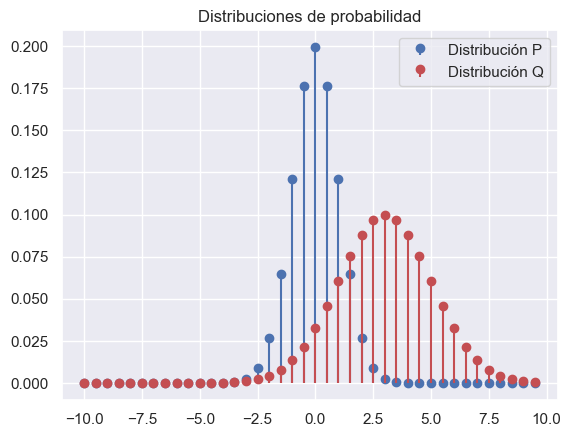

In [19]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

def kl_divergence(p, q):
    return np.sum(np.where(q != 0, p * np.log(p / q), 0))

x = np.arange(-10, 10, 0.5)  # Valores de x (eventos)

p = norm.pdf(x, 0, 1)  # Distribución normal estándar
p = p/np.sum(p)

q = norm.pdf(x, 3, 2)  # Distribución normal con media 3 y desviación estándar 2
q = q/np.sum(q)

plt.title('Distribuciones de probabilidad' % kl_divergence(p, q))

plt.stem(x, p, linefmt='b-', markerfmt='bo', basefmt=" ")  # Líneas verticales para p
plt.stem(x, q, linefmt='r-', markerfmt='ro', basefmt=" ")  # Líneas verticales para q

# Leyenda
plt.legend(['Distribución P', 'Distribución Q'])

print('KL(P||Q) = %1.3f' % kl_divergence(p, q))

### **Minimizando la divergencia KL**

Podemos utilizar la divergencia KL como función de pérdida para tratar de convertir una distribución en otra. En el siguiente código veremos cómo llevar la media y la desviación de una distribución normal $P = \mathcal{N}(0,\,1)$ hacia los valores de otra distribución normal $Q = \mathcal{N}(3,\,2)$ mediante la minimización del valor de KL.

Recordemos que la función de densidad de probabilidad de una distribución normal (o gaussiana) se define de la siguiente manera:

$$ \mathcal{N}(\mu,\,\sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{ - \frac{(x - \mu)^2}{2\sigma^2}  } $$

Esta fórmula describe una campana de Gauss, que es simétrica alrededor de su media $\mu$ y tiene una dispersión determinada por su desviación estándar $\sigma$.

In [45]:
import torch

start_mu = 0.
start_sigma = 1.

target_mu = 3.
target_sigma = 2.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_np = np.arange(-10, 10, 0.5)  # Valores de x (eventos). En total 40 valores
x = torch.from_numpy(x_np).float().to(device)  # Convertimos a tensor

mu = torch.tensor(start_mu, requires_grad=True, dtype=torch.float, device=device)
sigma = torch.tensor(start_sigma, requires_grad=True, dtype=torch.float, device=device)


optimizer = torch.optim.SGD([mu, sigma], lr=0.1)

def normal(x, _mu, _sigma):
    return 1./(_sigma * 2.506628) * torch.exp( (-(x - _mu)**2.) / (2. * _sigma**2.))  # sqrt(2 * pi) = 2.506628

def KL(p, q):
    return torch.where(q != 0, p * torch.log(p / q), torch.tensor([0.], device=device)).sum()
      
    # aux = torch.tensor(0., dtype=torch.float, device=device)    
    # for pv, qv in zip(p, q):                
    #     if qv > 1e-8:  # if qv != 0:                
    #         aux += pv * torch.log(pv / qv)    
    # return aux
    
tensor_target_mu = torch.tensor(target_mu, dtype=torch.float, device=device)
tensor_target_sigma = torch.tensor(target_sigma, dtype=torch.float, device=device)

P = normal(x, tensor_target_mu, tensor_target_sigma)
P = P / P.sum()

for i in range(150):  # para ir viendo cómo se van acercando las distribuciones, incrementa el número de iteraciones
    Q = normal(x, mu, sigma)
    Q = Q / Q.sum()

    loss = KL(P, Q)   
    
    loss.backward()
    optimizer.step()    
    optimizer.zero_grad()
    
    if i%10 == 0:
        print("Iteración:", i, "mu:", mu.data.cpu().numpy(), "sigma:", sigma.data.cpu().numpy(), "KL:", loss.data.cpu().numpy())



Iteración: 0 mu: 0.29973885 sigma: 2.1966615 KL: 5.2927322
Iteración: 10 mu: 0.7396919 sigma: 2.538774 KL: 0.4612211
Iteración: 20 mu: 1.0541651 sigma: 2.6397197 KL: 0.3446017
Iteración: 30 mu: 1.3141332 sigma: 2.6572855 KL: 0.27445024
Iteración: 40 mu: 1.5402694 sigma: 2.6318355 KL: 0.22164811
Iteración: 50 mu: 1.74163 sigma: 2.58114 KL: 0.17793246
Iteración: 60 mu: 1.9227753 sigma: 2.5154917 KL: 0.14036444
Iteración: 70 mu: 2.0860624 sigma: 2.442106 KL: 0.10792117
Iteración: 80 mu: 2.2326353 sigma: 2.3667052 KL: 0.08036424
Iteración: 90 mu: 2.3629782 sigma: 2.2940352 KL: 0.057703782
Iteración: 100 mu: 2.4773188 sigma: 2.2278705 KL: 0.039873354
Iteración: 110 mu: 2.5759542 sigma: 2.1708016 KL: 0.026543781
Iteración: 120 mu: 2.6594915 sigma: 2.124062 KL: 0.017094001
Iteración: 130 mu: 2.7289596 sigma: 2.0875857 KL: 0.010717981
Iteración: 140 mu: 2.7857707 sigma: 2.0603187 KL: 0.006591179


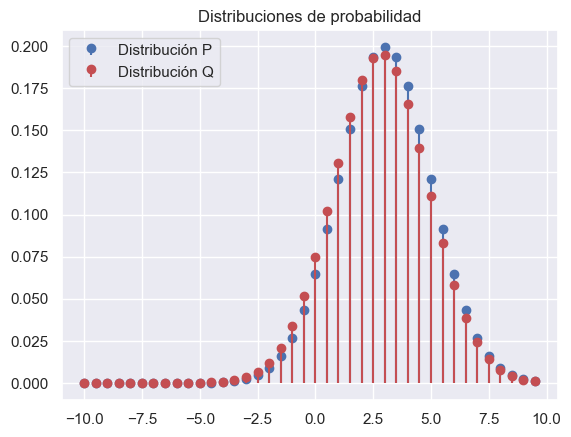

In [47]:
p = norm.pdf(x_np, target_mu, target_sigma)
q = norm.pdf(x_np, mu.data.cpu().numpy(), sigma.data.cpu().numpy())

plt.title('Distribuciones de probabilidad' % kl_divergence(p, q))
plt.stem(x.numpy(), p, linefmt='b-', markerfmt='bo', basefmt=" ")  # Líneas verticales para p
plt.stem(x.numpy(), q, linefmt='r-', markerfmt='ro', basefmt=" ")  # Líneas verticales para q

# Leyenda
plt.legend(['Distribución P', 'Distribución Q'])